Purpose of this notebook:

Trying to create a Speech-to-Text model from scratch using pytorch

In [1]:
import torch
import librosa
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading data from torchaudio datasets
dataset = torchaudio.datasets.LIBRISPEECH(root="data", url="train-clean-100", download=False) # set download to when you want to download the data

In [6]:
# Get the first sample (unpack all six values)
waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = dataset[0]

# Print details
print(f"Waveform shape: {waveform.shape}")
print(f"Sample rate: {sample_rate}")
print(f"Transcript: {transcript}")
print(f"Speaker ID: {speaker_id}")
print(f"Chapter ID: {chapter_id}")
print(f"Utterance ID: {utterance_id}")

Waveform shape: torch.Size([1, 225360])
Sample rate: 16000
Transcript: CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK
Speaker ID: 103
Chapter ID: 1240
Utterance ID: 0


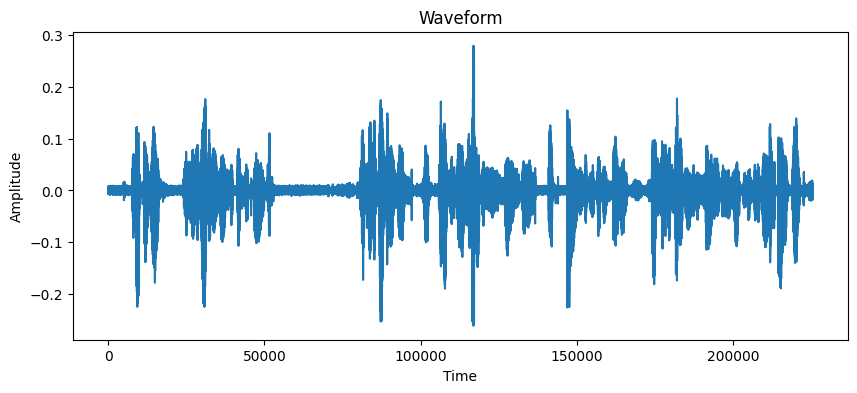

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(waveform[0].numpy())
plt.title("Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [8]:
# Compute the MFCCs using torchaudio
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_rate,
    n_mfcc=40,
    melkwargs={"n_fft":400, "hop_length":160, "n_mels":128}
)

mfcc = mfcc_transform(waveform)

c:\Users\Vishal\Github\Audio-Processing\venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


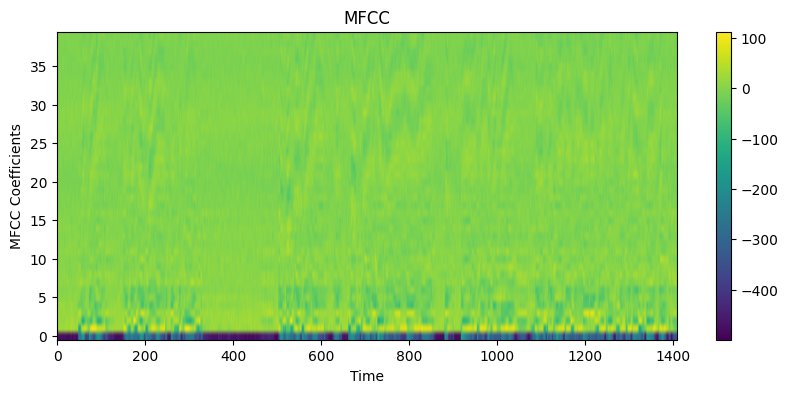

In [10]:
# visualize MFCCs
plt.figure(figsize=(10,4))
plt.imshow(mfcc[0].numpy(), cmap="viridis", origin="lower", aspect="auto")
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()

In [12]:
# Preparing the dataset
from torch.utils.data import DataLoader
import torch.utils.data.dataloader

class SpeechToTextDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = self.dataset[idx]
        mfcc = mfcc_transform(waveform) # Extracts MFCCs
        return mfcc.squeeze(0).transpose(0, 1), transcript # (time, n_mfcc), transcript

In [17]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Separate MFCCs and transcripts
    mfccs, transcripts = zip(*batch)
    
    # Pad MFCCs to the maximum length in the batch
    mfccs_padded = pad_sequence(mfccs, batch_first=True, padding_value=0.0)
    
    # Return padded MFCCs and transcripts
    return mfccs_padded, transcripts

In [18]:
# create dataset and dataloader
train_dataset = SpeechToTextDataset(dataset)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [19]:
# Check a batch
for batch in train_loader:
    mfccs_padded, transcripts = batch
    print(f"MFCCs shape: {mfccs_padded.shape}") # (batch, time, n_mfcc)
    print(f"Transcript: {transcripts}")
    break

MFCCs shape: torch.Size([8, 1593, 40])
Transcript: ('AS SOON AS THEY DISAPPEARED HE LANDED IN SEARCH OF HIS TUNIC AND SWORD AND AFTER SOME TROUBLE FOUND THEM AGAIN THEN HE MADE THE BEST OF HIS WAY ROUND THE LAKE TO THE OTHER SIDE THERE THE WOOD WAS WILDER', "THE TROPHIES LILY'S CONCEPTION OF SUCH ACHIEVEMENTS WAS EXTREMELY VAGUE BUT THIS WAS EXACTLY WHAT SHE HAD EXPECTED OF ISABEL TO GIVE IT FORM AND BODY", 'THAT NEVER HAS A FALL OF FULL GROWN FROGS BEEN REPORTED ALWAYS FROGS A FEW MONTHS OLD IT SOUNDS POSITIVE BUT IF THERE BE SUCH REPORTS THEY ARE SOMEWHERE OUT OF MY RANGE OF READING BUT TADPOLES WOULD BE MORE LIKELY TO FALL FROM THE SKY THAN WOULD FROGS', "BABE NOT BABY CORRECTED REBECCA FROM THE CIRCULAR IT'S JUST THE SAME THING ARGUED EMMA JANE OF COURSE IT'S JUST THE SAME THING BUT A BABY HAS GOT TO BE CALLED BABE OR INFANT IN A CIRCULAR", 'FROM THE MOMENT WHEN MARIUS TOOK HIS PLACE AND WAS THE SUBSTITUTE COSETTE WOULD NOT HAVE REGRETTED GOD HIMSELF SHE SET HER SWEET LITTLE FOOT',

In [20]:
# Building the model
import torch.nn as nn

class SpeechToTextModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(SpeechToTextModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.rnn = nn.LSTM(128, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        x = x.transpose(1, 2) # (batch, n_mfcc, time) -> (batch, time, n_mfcc)
        x = self.cnn(x)
        x = x.transpose(1, 2) # (batch, time, features) -> (batch, features, time)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

In [21]:
# initialize the model
input_dim = 40 # Number of MFCC Features
hidden_dim = 256
output_dim = 29 # 26 letters + space + apostrophe + blank (for CTC)
model = SpeechToTextModel(input_dim, hidden_dim, output_dim)
print(model)

SpeechToTextModel(
  (cnn): Sequential(
    (0): Conv1d(40, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): LSTM(128, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=29, bias=True)
)


In [22]:
# Defining the CTC loss
ctc_loss = nn.CTCLoss(blank=output_dim - 1) # Blank is the last index
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Training loop
def train(model, dataloader, optimizer, ctc_loss, epochs=5):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (mfccs, transcripts) in enumerate(dataloader):
            optimizer.zero_grad()
            outputs = model(mfccs)
            input_lengths = torch.full((mfccs.size(0),), outputs.size(1), dtype=torch.long)
            target_lengths = torch.tensor([len(t) for t in transcripts], dtype=torch.long)
            loss = ctc_loss(outputs.transpose(0, 1), transcripts, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item()}")

In [ ]:
# Train the model
train(model, train_loader, optimizer, ctc_loss, epochs=5)

In [ ]:
# Inference
def predict(model, mfcc):
    model.eval()
    with torch.no_grad():
        outputs = model(mfcc.unsqueeze(0))
        predicted_indices = torch.argmax(outputs, dim=2)
        return predicted_indices

In [ ]:
# Test on a sample
mfcc_sample, transcript_sample = train_dataset[0]
predicted_indices = predict(model, mfcc_sample)
print(f"Predicted: {predicted_indices}")